<a href="https://colab.research.google.com/github/kaniarasann/Langchain/blob/main/04_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prompt Chaining


---


Multiple prompts are sequenced togethor to guide a model through complex task or reasoning

In [39]:
#!pip install langchain langgraph langchain_groq pydantic

In [40]:
from langchain_groq import ChatGroq
from google.colab import userdata
groq_key = userdata.get('groq_key')

llm = ChatGroq(api_key=groq_key, model="meta-llama/llama-4-scout-17b-16e-instruct",)

In [41]:
llm.invoke("Hello")

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.057247193, 'prompt_time': 0.002745016, 'queue_time': 0.951330384, 'total_time': 0.059992209}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--96f98ca6-8336-40a2-be07-0e34161dc5ae-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [42]:
from typing_extensions import Annotated
from langgraph.graph import StateGraph,START,END
from IPython.display import display, Image
from pydantic import BaseModel

In [43]:
from typing import Optional
class State(BaseModel):
  topic:str
  story:Optional[str] =''
  improved_story:Optional[str] =''
  final_story:Optional[str] = ''


In [44]:
def generate_story(state:State) -> State:
  msg = llm.invoke(f"write a one sentence story premise about {state.topic}")
  state.story = msg.content
  return state

In [45]:
def check_conflit(state:State) -> str:
    if "?" in state.story or "!" in state.story :
      return "Fail"
    return "Pass"

In [46]:
def improved_story(state:State) -> State:
  msg = llm.invoke(f"Enhance this store with Vivid details : {state.story}")
  state.improved_story = msg.content
  return state


In [47]:
def polished_Story(state:State) -> State:
  msg = llm.invoke(f"Add an unexpected twist to this story premise: {state.improved_story}")
  state.final_story = msg.content
  return state

In [48]:
graph = StateGraph(State)

In [49]:
graph.add_node("generate",generate_story)
graph.add_node("improve",improved_story)
graph.add_node("polish",polished_Story)

In [50]:
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflit,{"Pass":"improve","Fail":"generate"})
graph.add_edge("generate","improve")
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

In [51]:
graph_builder = graph.compile()

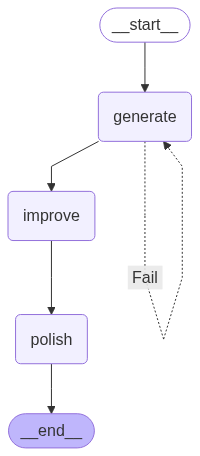

In [52]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [53]:
state = State(topic="The Great Gatsby")
res=graph_builder.invoke(state)

In [55]:
res['final_story']

"The Roaring Twenties Come Alive... in a world where magic is real.\n\nIn the sweltering summer of 1922, the opulent communities of Long Island's West Egg and East Egg pulsed with the vibrant energy of the Jazz Age, but with a twist: magic was a real and integral part of their world. The air was alive with the sweet scent of blooming flowers, the distant thrum of jazz music, and the soft glow of Art Deco lights that danced across the manicured lawns. But amidst the flapper dresses and suits, people possessed magical abilities that they kept hidden from the prying eyes of those who didn't understand.\n\nNick Carraway, a young and ambitious bond salesman from the Midwest, was no exception. Unbeknownst to him, he had a latent talent for spellcraft, inherited from his great-aunt, a powerful witch who had dabbled in the dark arts. As he became entranced by the mystical world of his enigmatic neighbor, Jay Gatsby, Nick began to discover his own magical abilities.\n\nGatsby's grand estate, wi